# A short demo on the Wavelet Detection Filter

We present here a brief example of usage of WDF for gravitational wave data analysis. WDF uses the pytsa (a python embedding for p4TSA) library for data preprocessing and searches for burst signals with a wavelet based method. Let's import some useful libraries:

In [1]:
import time
import os
import sys
from tempfile import NamedTemporaryFile
from pytsa.tsa import *
from pytsa.tsa import SeqView_double_t as SV
from pytsa.tsa import WaveletThreshold
from wdf.config.Parameters import *
from wdf.processes.wdfUnitDSWorker import * 
from wdf.observers.ParameterEstimationObserver import ParameterEstimation
from wdf.observers.SingleEventPrintFileObserver import SingleEventPrintTriggers
from wdf.processes.BandPassDownSampling import BandPassDownSampling
from wdf.processes.wdf import wdf
from wdf.processes.Whitening import Whitening 
from wdf.processes.DWhitening import DWhitening


from glob import glob
import json
import logging
import coloredlogs
import numpy as np
import matplotlib.pyplot as plt
coloredlogs.install(isatty=True)
import matplotlib
matplotlib.rcParams['agg.path.chunksize']=10000

%matplotlib inline

In [2]:
os.getcwd()

'/users/iess/GlitchClassification/notebooks'

We define a function to plot the data contained in the SequenceView Objects later on.

In [3]:
def plot_SV(data_sv, colour='b'):
    x = np.zeros(data_sv.GetSize())
    y = np.zeros(data_sv.GetSize())
    for i in range(data_sv.GetSize()):
        x[i] = data_sv.GetX(i)
        y[i] = data_sv.GetY(0,i)
    plt.plot(x,y, colour), plt.grid()
    return x, y

Importing script from my project repository:

In [4]:
sys.path.append("../scripts")
import segments
import get_git_repo_root

In [5]:
segments.get_list(tmin=1387513845, tmax=1387611370)       # values suggested by Francesco

[[1387513848.0, 1387609426.0]]

When launching WDF, we supply a number of parameters and configuration options. These parameters are loaded into WDF from a dictionary in a JSON configuration file.

In [6]:
results_dir = os.path.join(get_git_repo_root.repo_root(), 'results')
ffl_list = '/virgoData/ffl/raw.ffl'

configuration = {
   "sampling": 16384,
   "window": 512,                     # 512 --> wavelet window after resampling is 0.25 seconds
   "overlap": 128,                    # overlap between adjacent wavelet windows
   "threshold": 0.3,                  # stay between 0.2 and 0.5
   "len": 100.0,                       # length of data loaded in WDF loop at each iteration
   "ResamplingFactor":8,              # 16kHz---> 2kHz 
   "run": "run",                    # Name of the run, don't change
   'ID': 'test',
   'dir': results_dir,
   'file': ffl_list,            # can be the .gwf file or an ffl list of .gwf files 
   'channel': 'V1:Hrec_hoft_16384Hz',   # channel of data, gravitational wave strain from Virgo at 16kHz
   "outdir": results_dir,    # output directory for whitened data, keep same as dir
   "ARorder": 500, #edited from 1000         # Order of the autoregressive model, can set lower for synthetic noise
   "learn": 100, #edited from 100                # number of seconds at beginning of a segment, used to compute AR parameters
                                # check scipy.signal.welch for the welch spectrogram
   'preWhite':3,                    
#   'nproc': 4,
   'gps': 0.0,                 # if we want to provide gps to start analysis
    'segments': segments.get_list()[0]      # list of segments to analyze
    }                
 
filejson = os.path.join(results_dir,"test_configuration.json")
file_json = open(filejson, "w+")       
json.dump(configuration, file_json)
file_json.close()

print(filejson)

/users/iess/GlitchClassification/results/test_configuration.json


In [7]:
par = Parameters()
par.load(filejson)      
par.print()

{   'ARorder': 500,
    'ID': 'test',
    'ResamplingFactor': 8,
    'channel': 'V1:Hrec_hoft_16384Hz',
    'dir': '/users/iess/GlitchClassification/results',
    'file': '/virgoData/ffl/raw.ffl',
    'gps': 0.0,
    'learn': 100,
    'len': 10.0,
    'outdir': '/users/iess/GlitchClassification/results',
    'overlap': 128,
    'preWhite': 3,
    'run': 'run',
    'sampling': 16384,
    'segments': [1387470702.0, 1387497578.0],
    'threshold': 0.3,
    'window': 512}


## WDF downsampling

Before running WDF whitening procedure, we have to downsample the data to the desired frequency. Since our `par.ResamplingFactor = 8`, our initial frequency of 16 kHz shall be downsampled to 2 kHz.

In [8]:
par.resampling = int(par.sampling/par.ResamplingFactor)

In [9]:
par.ARfile = os.path.join(results_dir, "ARcoeff-AR%s-fs%s-%s.txt" % (
                par.ARorder, par.resampling, par.channel))
par.LVfile = os.path.join(results_dir, "LVcoeff-AR%s-fs%s-%s.txt" % (
                par.ARorder, par.resampling, par.channel))

In [10]:
gpsStart, gpsEnd = par.segments[0], par.segments[1]

if gpsEnd - gpsStart >= par.learn + 100.0:
    gpsE = gpsStart + 100.0
else:
    gpsE = gpsEnd - par.learn            

strLearn = FrameIChannel(par.file, par.channel, par.learn, gpsE) 
Learn = SV()
Learn_DS = SV()
ds = BandPassDownSampling(par,estimation=True)
strLearn.GetData(Learn)
Learn_DS=ds.Process(Learn)
    
del Learn, strLearn

Let us now plot the **DOWNSAMPLED STRAIN**, which we call *h*

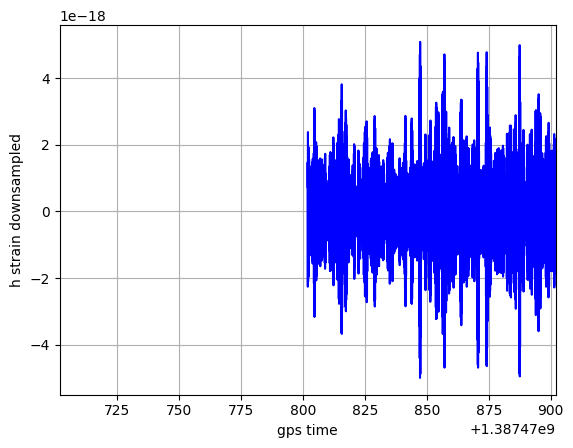

In [11]:
plot_SV(Learn_DS), plt.xlabel('gps time'), plt.ylabel('h strain downsampled'), plt.xlim(par.segments[0]+0, par.segments[0]+100+par.learn);


## WDF whitening

We now show how to whiten data with WDF. To do so, we have to give the `par.ARorder` parameter. Note that we use the downsampled SeqView object `Learn_DS` to evaluate the whitening parameters.

In [12]:
from wdf.processes.Whitening import Whitening
from wdf.processes.DWhitening import  DWhitening

In [13]:
whiten = Whitening(par.ARorder)

In [14]:
if os.path.isfile(par.ARfile):
    whiten.ParametersLoad(par.ARfile, par.LVfile)
    print(f'Parameters loaded from {par.ARfile}')
else:
    whiten.ParametersEstimate(Learn_DS)
    whiten.ParametersSave(par.ARfile, par.LVfile)
    print('Parameters saved.')

Parameters loaded from /users/iess/GlitchClassification/results/ARcoeff-AR500-fs2048-V1:Hrec_hoft_16384Hz.txt


In [15]:
par.sigma = whiten.GetSigma()

In [16]:
par.sigma

1.26693e-21

In [16]:
data_sample = SV()
datads_sample = SV()
dataw_sample = SV()

stream_sample = FrameIChannel(par.file, par.channel, 200.0, par.segments[0]+200.0) 
stream_sample.GetData(data_sample)

ds = BandPassDownSampling(par,estimation=True)
datads_sample=ds.Process(data_sample)

whiten.Process(datads_sample, dataw_sample)

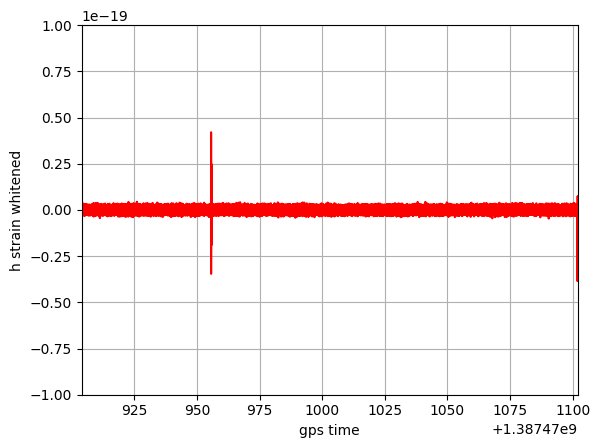

In [17]:
plot_SV(dataw_sample, colour='r'), plt.xlabel('gps time'), plt.ylabel('h strain whitened');
plt.xlim(par.segments[0]+200+2,par.segments[0]+400), plt.ylim(-1e-19, 1e-19);

## Full WDF

We have shown how to whiten data with WDF. Now we show how to carry out an analysis with WDF, consisting of a number of steps: 1) **DOWNSAMPLING**, **WHITENING**, **WAVELET TRANSFORM & TRIGGER EXTRACTION**. We will have to redefine the sequence views for the raw and whitened data. 

In [17]:
double_white = False

In [18]:
par.gps = par.segments[0]
par.gpsEnd = par.segments[1]

In [19]:
segment_length = par.segments[1]-par.segments[0]
par.Ncoeff = par.window

savetrigger = SingleEventPrintTriggers(par, fullPrint=3)
parameterestimation = ParameterEstimation(par)
parameterestimation.register(savetrigger)
WDF = wdf(par)
WDF.register(parameterestimation)
    
streaming = FrameIChannel(par.file, par.channel, par.len, par.segments[0])
data = SV()
data_ds = SV()
dataw = SV()
count = 0

logging.info('Starting Detection Loop')

2024-02-26 16:16:05 servergpu1.virgo.infn.it root[12866] INFO Starting Detection Loop


In [20]:
while data.GetStart() <=par.gpsEnd:
    streaming.GetData(data)
    data_ds=ds.Process(data)
    if double_white:
        DW.Process(data_ds, dataw)
    else:
        whiten.Process(data_ds, dataw)
    if count%10==0:
        print('loop ' +str(data.GetStart()))
    WDF.SetData(dataw)
    WDF.Process()
    count+=1

loop 1387470702.0


KeyboardInterrupt: 

In [ ]:
BandPassDownSampling??